In [5]:
%matplotlib inline

import pyopencl as cl
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

#import configure as cfg

class CL():
    def __init__(self, A, r, nx):
        #self.shape = A.shape
        self.clinit()
        self.loadData(A, r)
        self.nx = nx
        self.na = A.shape[0]
        #self.block_size = 128
        self.program = self.loadProgram("cl.cl")

    def clinit(self):
        self.ctx = cl.create_some_context()       
        self.queue = cl.CommandQueue(self.ctx) 

    def loadProgram(self, filename):
        f = open(filename, 'r')
        fstr = "".join(f.readlines())
        kernel_params = {"nx": self.nx, "na": self.na}
        return cl.Program(self.ctx, fstr % kernel_params).build()  
        
    def loadData(self, A, r):
        self.size = X.nbytes
        
        mf = cl.mem_flags        
        self.A = cl.Buffer(self.ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=A)
        self.r = cl.Buffer(self.ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=r)
        self.I = cl.Buffer(self.ctx, mf.READ_WRITE, self.size/4)
        self.queue.finish()
   
    def loadX(self, X):
        mf = cl.mem_flags
        self.X = cl.Buffer(self.ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=X)
        
    def run(self, X):
        self.loadX(X)
        self.program.Solve(self.queue, (self.nx, self.na), None, self.A, self.r, self.X, self.I)
        cl.enqueue_barrier(self.queue)
        return self
            
    def get(self):
        self.out = np.zeros((self.nx,), dtype = np.float32)
        cl.enqueue_copy(self.queue, self.out, self.I)
        self.queue.finish()
        return self.out

N = 12


Rn = (np.random.random([N,3]))

#Rn = np.array([[0.25,0.25,0.25],[0.75,0.25,0.25],[0.25,0.75,0.25],[0.25,0.25,0.75],
#              [0.75,0.75,0.25],[0.25,0.75,0.75],[0.75,0.25,0.75],[0.75,0.75,0.75]])

tes = Delaunay(Rn).simplices

R = Rn[tes,:]
A1 = np.linalg.inv(np.transpose([[R[:,i,j]-R[:,3,j]
                                 for j in range(0,3)] for i in range(0,3)],[2,1,0]))
    
na = A1.shape[0]

nx = 128*512


A = np.zeros((na,3,4), dtype = np.float32)
#A[:,:,0:3] = np.random.random((na,4,3))
A[:,:,0:3] = A1
A[:,:,3] = 1.
X = np.zeros((nx,4), dtype = np.float32)
X[:,0:3] = np.random.random((nx,3))
X[:,3] = 1.
r = np.zeros((na,4), dtype = np.float32)
#r[:,0:3] = np.random.random((na,3))
r[:,0:3] = R[:,3,:]
r[:,3] = 1.

q = CL(A,r,nx).run(X)
I = q.get()

img = np.zeros([512,512],dtype = np.float)
xi = np.floor(X[:,0]*512).astype(np.int)
yi = np.floor(X[:,1]*512).astype(np.int)
img[xi,yi] = I

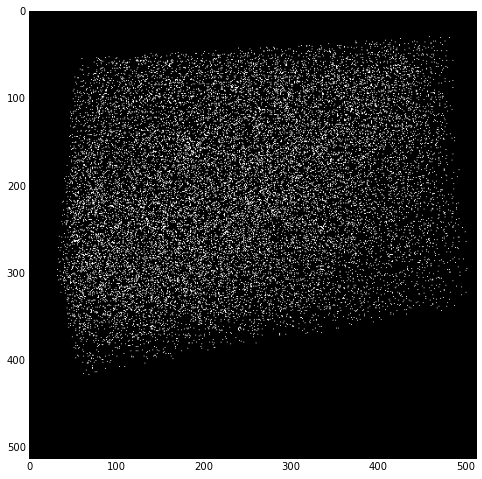

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray', interpolation = 'bilinear')

In [5]:
na

6